
# Predicting the VIX

This notebook builds a probabilistic forecast for the VIX. Instead of predicting a single future value, we model the full distribution of possible changes in VIX, conditional on its current level. With that conditional distribution in hand, we can draw scenarios, compute prediction bands (fan charts), and summarize risk in a way that reflects how the VIX behaves differently in calm versus turbulent markets.


This notebook:
1. Loads daily VIX history and builds a series `x = log(CLOSE)`.
2. Fits a **2D GMM** on pairs `(x_t, x_{t+1} - x_t)`.
3. Builds the conditional model $p(x_{t+1} - x_t\mid x_t)$.
4. Plots the posterior mean function $\mathbb{E}[x_{t+1} - x_t \mid x_t]$.
5. Simulates multi-step scenarios by iteratively sampling from the conditional.


## Loading the VIX data

The code below reads the historical VIX series from file, parses the date column, and sets it as the time index so that later time-based operations behave correctly. It also standardizes column names and drops any rows with missing values, ensuring the dataset is clean and ready for transformations and modeling.

In [1]:

# Use Jupyter inline backend so figures render in HTML builds
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

import os, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

from cgmm import GMMConditioner, ConditionalGMMRegressor

VIX_URL = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
CANDIDATE_PATHS = [
    os.environ.get("VIX_CSV", ""),
    "data/VIX_History.csv",
    "docs/_static/VIX_History.csv",
]

def load_vix():
    for p in CANDIDATE_PATHS:
        if p and os.path.exists(p):
            df = pd.read_csv(p)
            print(f"Loaded local CSV: {p}")
            break
    else:
        # Only download if allowed (avoid on RTD)
        allow_net = os.environ.get("ALLOW_NET", "1") not in ("0","false","False")
        if os.environ.get("READTHEDOCS","") or not allow_net:
            raise FileNotFoundError(
                "VIX_History.csv not found locally and network disabled. "
                "Place it at docs/_static/VIX_History.csv or set VIX_CSV=/path/to/file."
            )
        import urllib.request
        print("Downloading VIX history ...")
        with urllib.request.urlopen(VIX_URL) as f:
            data = f.read()
        df = pd.read_csv(io.BytesIO(data))
        os.makedirs("data", exist_ok=True)
        df.to_csv("data/VIX_History.csv", index=False)
        print("Saved to data/VIX_History.csv")
    df = df.rename(columns=str.upper)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.sort_values("DATE").reset_index(drop=True)
    return df

df = load_vix()
print(df.head())


Loaded local CSV: data/VIX_History.csv
        DATE   OPEN   HIGH    LOW  CLOSE
0 1990-01-02  17.24  17.24  17.24  17.24
1 1990-01-03  18.19  18.19  18.19  18.19
2 1990-01-04  19.22  19.22  19.22  19.22
3 1990-01-05  20.11  20.11  20.11  20.11
4 1990-01-08  20.26  20.26  20.26  20.26


## Compute x=log(VIX) and it's daily change

Here we transform the raw VIX level to log-space and compute its one-day change. Taking logs stabilizes the scale (large and small values become more comparable), and differencing the log series isolates day-to-day movements. The result is a target variable (the log change) and a conditioning variable (the log level) aligned on the same dates, with any initial NaN from differencing removed.

In [2]:
log_vix = np.log(df["CLOSE"].astype(float).to_numpy())

x = log_vix[:-1]
dx = log_vix[1:] - log_vix[:-1]

pairs = np.column_stack((x, dx))

## Fit a regression model

This section fits a simple regression of the daily log change on the current log level. The goal is to capture the average relationship—e.g., whether VIX tends to drift up or down depending on where it currently sits.

In [3]:
# fit a Conditional GMM, x = current log VIX, y = next log VIX change
reg = ConditionalGMMRegressor(cond_idx=[0]).fit(X=x.reshape(-1,1), y=dx)

# Grid over original x coordinates
grid_x = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)

# conditional expectation on the grid: E[dS | S]
grid_dx_pred = reg.predict(grid_x[:, None]).ravel()

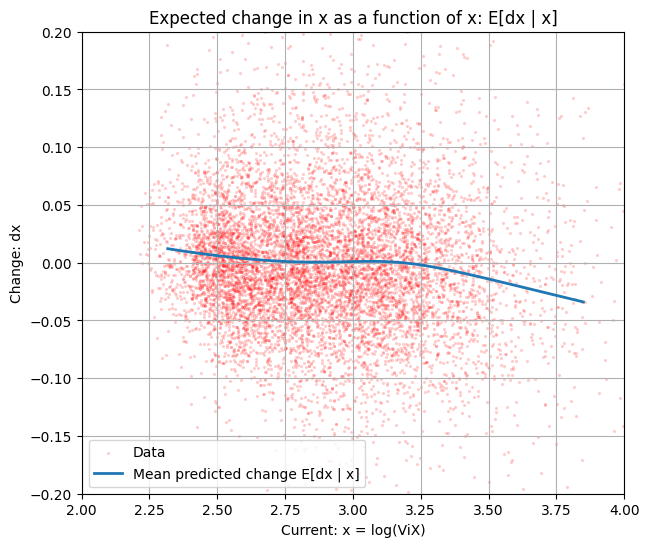

In [4]:

fig, ax = plt.subplots(figsize=(7,6))

# Scatter  the log VIX data
ax.scatter(x, dx, s=5, alpha=0.2, linewidths=0, c='r', label="Data")

# The predicted mean
ax.plot(grid_x, grid_dx_pred, lw=2, label="Mean predicted change E[dx | x]")


ax.set_xlim(2, 4)
ax.set_ylim(-0.2, 0.2)

ax.set_xlabel("Current: x = log(ViX)")
ax.set_ylabel("Change: dx")
ax.set_title("Expected change in x as a function of x: E[dx | x]")
ax.legend(loc="best")
ax.grid()
plt.show()


## Fit a condtion model

Now we fit the conditional distribution of the daily log change given the current log level using a Conditional Gaussian Mixture Model (CGMM). Instead of a single bell curve, the model represents the outcome as a mixture of Gaussians whose weights and parameters adapt with the conditioning variable. This lets the shape of the distribution change with the level—capturing skew, fat tails, and non-linearity that a plain regression can't. After training, we plot confitional densities of the next-day-chage, for different values of current level.


In [5]:
K = 3
gmm = GaussianMixture(n_components=K, covariance_type="full", random_state=0).fit(pairs)
cond = GMMConditioner(gmm, cond_idx=[0], reg_covar=1e-9).precompute()

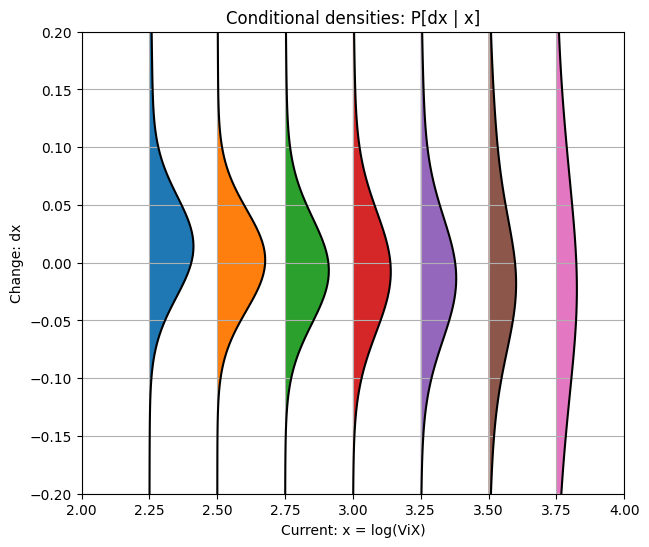

In [6]:
fig, ax = plt.subplots(figsize=(7,6))

y_i = np.linspace(-0.2, 0.2, 100)

for x_i in np.arange(2.25, 4, 0.25):
    cgmm = cond.condition([x_i])
    p_y = np.exp(cgmm.score_samples(y_i.reshape(-1,1)))
    ax.fill_betweenx(y_i, x_i, x_i + 0.02*p_y)
    ax.plot(x_i + 0.02*p_y, y_i, 'k-')

ax.set_xlim(2, 4)
ax.set_ylim(-0.2, 0.2)    
ax.grid()
ax.set_xlabel("Current: x = log(ViX)")
ax.set_ylabel("Change: dx")
ax.set_title("Conditional densities: P[dx | x]")
plt.show()    

## Monte Carlo path simulation

Using the fitted conditional model, we simulate many forward paths. Starting from today’s log level, each step draws a daily log change from the learned distribution conditional on the current level, updates the level, and repeats for the desired horizon. Converting back from log space yields VIX trajectories. Aggregating these paths produces a fan chart (e.g., median and 10–90% bands) that reflects both drift and state-dependent volatility and tail risk.

In [23]:
import numpy as np

def simulate_paths_delta(cond, x0, horizon=60, n_paths=400, seed=123):
    rng = np.random.default_rng(seed)
    xs = np.empty((n_paths, horizon + 1), dtype=float)

    for i in range(n_paths):
        xt = float(x0)
        xs[i, 0] = xt
        for t in range(horizon):
            gmmd = cond.condition([xt])  # posterior over Δ (1D GMM)
            gmmd.random_state = int(rng.integers(0, 2**32 - 1))
            y, _ = gmmd.sample(1)
            xt = xt + float(y[0, 0])     # x_{t+1} = x_t + Δ
            xs[i, t + 1] = xt
    return xs

# Run scenarios starting from last observed x
H, N = 60+40, 1000
xs_paths = simulate_paths_delta(cond, x0=x[-1], horizon=H, n_paths=N)
vix_paths = np.exp(xs_paths)  # back to VIX level


## Gallery Image

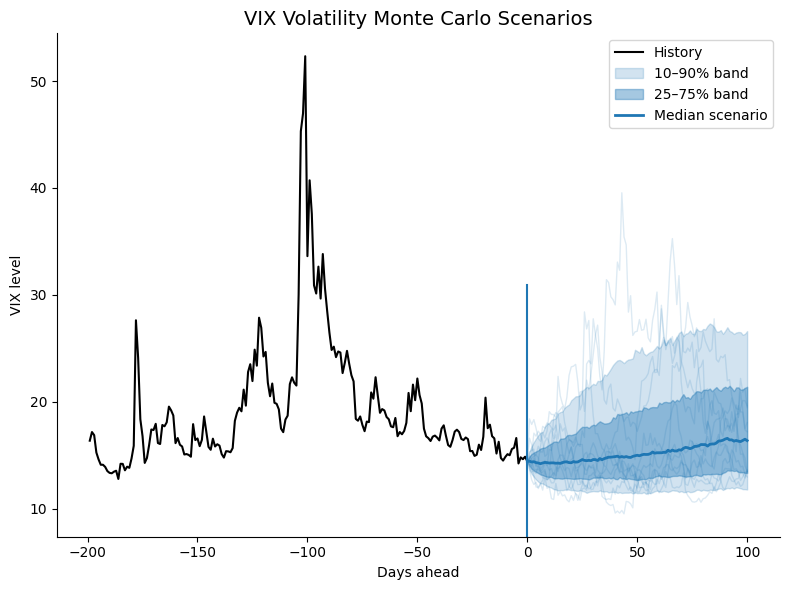

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

hist_n = 200
ax.plot(np.arange(-hist_n+1, 1), np.exp(x[-hist_n:]),
        color="k", lw=1.5, label="History")

q = np.quantile(vix_paths, [0.1, 0.25, 0.5, 0.75, 0.9], axis=0)
t = np.arange(H+1)
ax.fill_between(t, q[0], q[-1], color="tab:blue", alpha=0.2, label="10–90% band")
ax.fill_between(t, q[1], q[-2], color="tab:blue", alpha=0.4, label="25–75% band")
ax.plot(t, q[2], color="tab:blue", lw=2, label="Median scenario")

for i in range(min(10, N)):
    ax.plot(t, vix_paths[i], color="tab:blue", alpha=0.15, lw=1)

ax.set_xlabel("Days ahead")
ax.set_ylabel("VIX level")
ax.set_title("VIX Volatility Monte Carlo Scenarios", fontsize=14)
ax.axvline(x=0,ymin=0,ymax=.50)
ax.spines[['right', 'top']].set_visible(False)
ax.legend()
plt.tight_layout()
plt.savefig('gallery_images/vix.png', dpi=150, bbox_inches='tight')

plt.show()
